In [18]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist

from tqdm import tqdm

from sklearn.metrics import mean_squared_error

In [2]:
class GR4J(nn.Module):

    def __init__(self, s_init=0, r_init=0):
        super(GR4J, self).__init__()
        self.s_init = s_init
        self.r_init = r_init
        self.x1 = torch.tensor(109.37118080390698)#dist.uniform.Uniform(100, 1200).sample()
        self.h1 = nn.Linear(4, 32)
        self.h2 = nn.Linear(32, 16)
        self.h3 = nn.Linear(16, 4)
        self.o = nn.Linear(4, 1)

    
    def forward(self, prec, etp):
        
        # Number of simulation timesteps
        num_timesteps = len(prec)
        
        # Unpack the model parameters
        x1 = self.x1

        # Production Storage
        p_n = torch.relu(prec - etp)
        e_n = torch.relu(etp - prec)

        # Production store
        num_timesteps = len(prec)
        p_s = torch.zeros(num_timesteps)
        e_s = torch.zeros(num_timesteps)
        perc = torch.zeros(num_timesteps)
        s_store = torch.zeros(num_timesteps + 1)
        s_store[0] = self.s_init * x1

        for t in range(num_timesteps):
            # calculate fraction of netto precipitation that fills
            #  production store (eq. 3)
            p_s[t] = ((x1 * (1 - (s_store[t-1] / x1)**2) * torch.tanh(p_n[t]/x1)) /
                (1 + s_store[t-1] / x1 * torch.tanh(p_n[t] / x1)))

            # from the production store (eq. 4)
            e_s[t] = ((s_store[t-1] * (2 - s_store[t-1]/x1) * torch.tanh(e_n[t]/x1)) 
                / (1 + (1 - s_store[t-1] / x1) * torch.tanh(e_n[t] / x1)))

            s_store[t] = s_store[t - 1] + p_s[t] - e_s[t]

            # calculate percolation from actual storage level
            perc[t] = s_store[t] * (1 - (1 + (4/9 * s_store[t] / x1)**4)**(-0.25))
            
            # final update of the production store for this timestep
            s_store[t] = s_store[t] - perc[t]

        # Expand dim
        p_n = p_n[:, None]
        e_n = e_n[:, None]
        p_s = p_s[:, None] 
        perc = perc[:, None]
        
        # Concatenate
        inp = torch.concat([p_n, e_n, p_s, perc], dim=1)

        # ANN
        out = self.h1(inp.float())
        out = torch.relu(self.h3(self.h2(out)))
        out = torch.relu(self.o(out)).flatten()

        return out

In [3]:
data_location = os.path.join('/data')

In [4]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [5]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [6]:
def softplus(x):
    return np.log(x+1)

def desoftplus(x):
    return np.exp(x)-1

In [7]:
# maulescreek_streamflow['Log Value'] = softplus(maulescreek_streamflow['Value'])

In [8]:
# sns.lineplot(x='Date', y='Log Value', data=maulescreek_streamflow)
# sns.lineplot(x='Date', y='Value', data=maulescreek_streamflow)

In [9]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [10]:
# Tune GR4J parameters
prcp_calib = torch.from_numpy(calibration_data.loc[:, 'Rain'].values.astype('float32'))
et_calib = torch.from_numpy(calibration_data.loc[:, 'FAO56'].values.astype('float32'))
flow_calib = torch.from_numpy(calibration_data.loc[:, 'Value'].values.astype('float32'))
date_calib = calibration_data.loc[:, 'Date'].values


In [19]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def normalize(x):
    return 1/(2 - x)

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model(prcp, et)

    # Desoftplus
    flow_pred = flow_pred.detach().numpy()
    flow = flow.detach().numpy()

    nse_score = nse(flow, flow_pred)
    nnse_score = normalize(nse_score)

    print(f"MSE: {mean_squared_error(flow, flow_pred):4f}")

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, softplus(flow), color='black', label='obs', alpha=1.0)
    ax.plot(dates, softplus(flow_pred), color='red', label='pred', alpha=0.7)
    # ax.plot(dates, prcp.detach().numpy(), 'g--', label='precip', alpha=0.45)
    # ax.plot(dates, et.detach().numpy(), 'y--', label='etp', alpha=0.45)

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

    return flow_pred, flow

In [12]:
model = GR4J()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
result = model(prec=prcp_calib, etp=et_calib)
result

tensor([0.3797, 0.3826, 0.4057,  ..., 0.0874, 0.3132, 0.3392],
       grad_fn=<ReshapeAliasBackward0>)

In [13]:
N = 200

pbar = tqdm(range(N))

for epoch in pbar:

    opt.zero_grad()

    pred_flow = model(prcp_calib, et_calib)

    loss = torch.nn.functional.mse_loss(flow_calib, pred_flow)

    loss.backward()

    opt.step()

    pbar.set_description(f"Epoch {epoch+1} loss: {loss.detach().numpy():.4f}")

Epoch 200 loss: 28.2797: 100%|██████████| 200/200 [02:27<00:00,  1.36it/s]


MSE: 43.904715
NSE: -0.044
Normalized NSE: 0.489


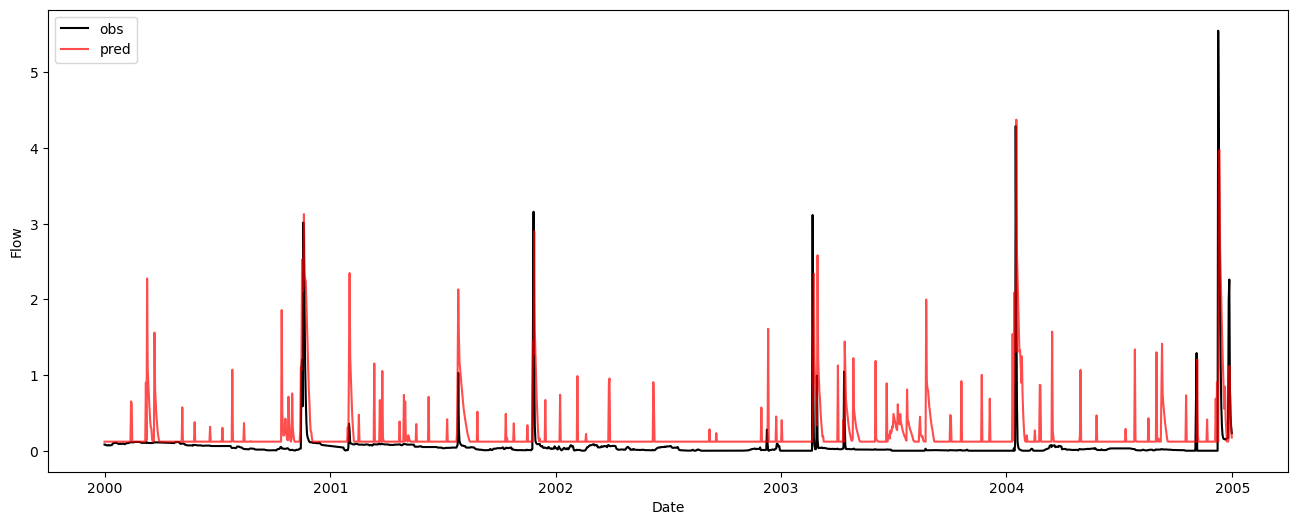

In [20]:
# Evaluate on unseen data
prcp_holdout = torch.from_numpy(holdout_data.loc[:, 'Rain'].values)
et_holdout= torch.from_numpy(holdout_data.loc[:, 'FAO56'].values)
flow_holdout = torch.from_numpy(holdout_data.loc[:, 'Value'].values)
date_holdout = holdout_data.loc[:, 'Date'].values

pred_flow, flow = evaluate(model, date_holdout, et_holdout, prcp_holdout, flow_holdout)